## Build a Multilayer Convolutional Network

92% is pretty bad, lets improve on it.

### Weight Initialization

One should generally initialize weights with a small amount of noise for symmetry breaking and to prevent 0 gradients (wut).

check out:https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
# from sklearn.metrics import confusion_matrix
# import time
# from datetime import timedelta
# import math

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Set up
# Create the model
x = tf.placeholder(tf.float32, [None, 784])
# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])

In [4]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

### Convolution and Pooling

Our convolutions uses a stride of one and are zero padded so that the output is the same size as the input. Our pooling is plain old max pooling over 2x2 blocks. To keep our code cleaner, let's also abstract those operations into functions.

In [5]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

### First Layer

COnsist of convolution, followed by max pooling. Compute 32 features for each 5x5 patch. Weight tensor will have shape of `[5, 5, 1, 32]`

In [6]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

To apply the layer, we first reshape x to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels

In [7]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [8]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

### Second Convolutional Layer

In [9]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

### Densely Connected Layer

In [10]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### Readout Layer
(skip drop out for now)

In [11]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2


### Train and Evaluate the Model

In [12]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
with sess.as_default():
    for i in range(500):
        batch = mnist.train.next_batch(50)
    if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
          x: batch[0], y_: batch[1]})
        print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})

    print('test accuracy %g' % accuracy.eval(feed_dict={
      x: mnist.test.images, y_: mnist.test.labels}))


## Exporting the Model

Now that we are happy with the model's performance, we can export it for use in our applications. Use `tf.train.Saver()` to save the graph and the trained weights.

In [16]:
model_path = "./tmp/model.ckpt"

# Running first session
print("Starting 1st session...")
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(200):
    batch = mnist.train.next_batch(50)
    if i % 100 == 0:
      train_accuracy = accuracy.eval(feed_dict={
              x: batch[0], y_: batch[1]})
      print('step %d, training accuracy %g' % (i, train_accuracy))
      train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
  # Save model weights to disk
  save_path = saver.save(sess, model_path)
  print("Model saved in file: %s" % save_path)
  print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))


Starting 1st session...
step 0, training accuracy 0.18
step 100, training accuracy 0.88
Model saved in file: ./tmp/model.ckpt
Accuracy: 0.902


To restore the session:

In [14]:
saver = tf.train.Saver()
model_path = "./tmp/model.ckpt"
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  saver.restore(sess, model_path)
  print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))


INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt
Accuracy: 0.9777


In [15]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  saver.restore(sess, model_path)
  img = mnist.test.images[2]
  print(sess.run(tf.argmax(y_conv, 1), {x:[img]}))

INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt
[1]
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.         

In [40]:
print(type(mnist.test.images[2]))
print(mnist.test.images[2].ndim)
import cv2
im = cv2.imread("screenshot.png")
# print(im.shape)
temp = im.reshape(28*28, 3)
trans_temp = [1-i[0]/255 for i in temp]
# print(trans_temp)
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  saver.restore(sess, model_path)
  img = mnist.test.images[2]
  print(sess.run(tf.argmax(y_conv, 1), {x:[trans_temp]}))

<class 'numpy.ndarray'>
1
INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt
[4]


We should get the same accuracy since it is the same model.

We can now export our trained model for use in our applications. Alternatively, you can use [TensorFlow Serving components](https://www.tensorflow.org/serving/serving_basic) to export a trained TensorFlow model and use the standard tensorflow_model_server to serve it.

In [32]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((28, 28)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

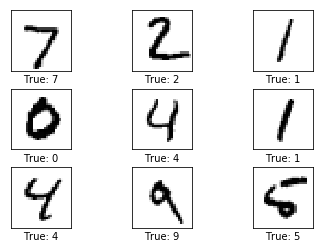

In [33]:
import numpy as np
# Get the first images from the test-set.
images = mnist.test.images[0:9]

# Get the true classes for those images.
mnist.test.cls = np.argmax(mnist.test.labels, axis=1)
cls_true = mnist.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [ ]:
with 